# Определение перспективного тарифа для телеком-компании

Телекомкомпания предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
calls=pd.read_csv('/datasets/calls.csv')
internet=pd.read_csv('/datasets/internet.csv').drop(['Unnamed: 0'],axis = 1) #Сразу удалим лишний столбец, т.к. по условию задачи его не должно быть там
messages=pd.read_csv('/datasets/messages.csv')
tariffs=pd.read_csv('/datasets/tariffs.csv')
users=pd.read_csv('/datasets/users.csv')

In [3]:
# Изначально создаем словарь названий таблиц и данных
slovar ={
    'calls': calls,
    'internet': internet,
    'messages': messages,
    'tariffs': tariffs,
    'users': users 
}

In [4]:
# Теперь напишем функцию, создающую датафрейм с удобным отображением результата функции .info() по всем датасетам
def stat(dict_of_frames):
    """Функция для агрегации данных о нескольких загруженных таблицах.
    Собирает следующею информацию: количество объектов(строк) в данных,
    количество null-значений и тип каждого столбца
    """
    def table(dataframe, name): #

        columns = dataframe.columns #Список столбцов
        count_of_columns = len(columns) #Количество столбцов
        total = dataframe.shape[0] #Количество строк датафрейма
        
        part_total_table = pd.DataFrame(data =[[0] * 6] * count_of_columns, 
                                        columns = ['total',
                                                   'frame',
                                                   "columns",
                                                   "null_values",
                                                   "type",
                                                  "duplicated"]) #Создаем датафрейм с столбцами, добавляя строки
    
        part_total_table['total'] = [total] * count_of_columns #Добавляем в столбец 'total'
        part_total_table['frame'] = [name] * count_of_columns #Добавляем в столбец 'name'
        part_total_table['columns'] = columns #Добавляем столбцы
        for column in columns: 
            curent_type = str(dataframe[column].dtype) #Часть цикла, которая покажет тип данных значений в столбце
            count_of_duplucated = dataframe[column].duplicated().sum()#!!!!!!!!посчитаем дубликаты!!!!!!!!!
            count_of_null = dataframe[column].isnull().sum() #Часть цикла, которая посчитает пропущенные значения в столбце
            part_total_table.loc[part_total_table['columns'] == column,'null_values'] = count_of_null
            part_total_table.loc[part_total_table['columns'] == column,'type'] = curent_type
            part_total_table.loc[part_total_table['columns'] == column,'duplicated'] = count_of_duplucated #!!!!!!!!применим к столбце подсчет дубликатов!!!!!!!!!
        return part_total_table
        
    final_frame = pd.DataFrame(columns = ['total','frame',"columns","null_values","type","duplicated"]) #Добавляем в датафрейм столбцы с названиями, !!!+столбец с дубликатами
    
    for name,frame in dict_of_frames.items(): #Используем .items(), чтобы перебрать строки
        part_of_table = table(frame,name)
        final_frame = final_frame.append(part_of_table)
        
    final_frame = final_frame.reset_index(drop = True) #Обновляем индексацию
    final_frame_grouped = final_frame.groupby(['total','frame',"columns"]).sum()
    
    return final_frame_grouped

In [5]:
stat(slovar)

null_values     type  duplicated
total  frame    columns                                                
2      tariffs  mb_per_month_included            0    int64           0
                messages_included                0    int64           0
                minutes_included                 0    int64           0
                rub_monthly_fee                  0    int64           0
                rub_per_gb                       0    int64           0
                rub_per_message                  0    int64           0
                rub_per_minute                   0    int64           0
                tariff_name                      0   object           0
500    users    age                              0    int64         442
                churn_date                     462   object         466
                city                             0   object         424
                first_name                       0   object         254
                last_name                        0   object          81
                reg_date                         0   object         230
                tariff                           0   object         498
                user_id                          0    int64           0
123036 messages id                               0   object           0
                message_date                     0   object      122672
                user_id                          0    int64      122610
149396 internet id                               0   object           0
                mb_used                          0  float64       79393
                session_date                     0   object      149031
                user_id                          0    int64      148899
202607 calls    call_date                        0   object      202242
                duration                         0  float64      199736
                id                               0   object           0
                user_id                          0    int64      202115

In [6]:
users['churn_date'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: churn_date, dtype: object

На выходе получаем датафрейм с сформированными данными в очень удобном виде
Замечаем пропущенные значения в столбце "churn_date"
Также необходимо изменить тип данный на datatime у 5 столбцов

## Предобработка данных

In [8]:
columns_to_datetime = {"reg_date":users,
                       "message_date":messages,
                       "session_date":internet,
                       "call_date":calls} #Создадим словарь с столбцами, у которых нужно изменить тип данных на datatime

for column, frame in columns_to_datetime.items():
    frame[column] = pd.to_datetime(frame[column],format = '%Y-%m-%d') #Цикл, меняющий тип данных 

In [10]:
#Теперь добавим столбцы с месяцами в таблицы
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

## Расчёты и добавление результатов в таблицу

In [11]:
#По условию задачи, округлим значения длительности вызова и количества использованного интернет-трафика в большую сторону
calls['duration']=np.ceil(calls['duration']).astype(int)

In [12]:
#Объединим таблицы звонков и сообщенй по id и month пользователя и заменим названия столбцов для удобства
calls_group=calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
calls_group = calls_group.rename(columns={'count': 'calls_count','sum': 'minutes'})#rename
messages_group=messages.groupby(['user_id', 'month'])['id'].agg(['count']).reset_index()
messages_group = messages_group.rename(columns={'count': 'count_messages'})#rename
internet_group=internet.groupby(['user_id', 'month'])['mb_used'].agg(['sum']).reset_index()
internet_group = internet_group.rename(columns={'sum': 'count_mb'})#rename


In [13]:
#Объединим таблицы в одну
id_user=pd.merge(calls_group,messages_group, how='outer')
id_user=pd.merge(id_user,internet_group, how='outer')
id_user=pd.merge(id_user,users.loc[:,['user_id','tariff','city']], how='outer')

Расчитаем помесячную выручку с каждого пользователя

In [15]:
id_user.isna().sum()

user_id             0
month               2
calls_count        42
minutes            42
count_messages    499
count_mb           13
tariff              0
city                0
dtype: int64

In [16]:
#Тут строки, где значение равно 0.
print(id_user[id_user['count_mb']==0])
print(id_user[id_user['count_messages']==0])
print(id_user[id_user['minutes']==0])
print(id_user[id_user['calls_count']==0])

      user_id  month  calls_count  minutes  count_messages  count_mb tariff  \
584      1094    5.0         16.0    107.0             3.0       0.0  ultra   
2278     1365   10.0          5.0     43.0             1.0       0.0  smart   

                city  
584      Новосибирск  
2278  Ростов-на-Дону  
Empty DataFrame
Columns: [user_id, month, calls_count, minutes, count_messages, count_mb, tariff, city]
Index: []
      user_id  month  calls_count  minutes  count_messages  count_mb tariff  \
1493     1240    2.0          2.0      0.0             NaN    959.51  ultra   
1605     1257    7.0          1.0      0.0           146.0  20014.22  ultra   
1606     1257    8.0          2.0      0.0           157.0  25482.16  ultra   
1607     1257    9.0          1.0      0.0           153.0  22753.12  ultra   
2318     1373    1.0          2.0      0.0            28.0   9173.74  smart   
2321     1373    4.0          1.0      0.0            48.0  20375.78  smart   

                 city  
1

In [17]:
#Пропуски заполним нулями, пропуск в месяце заполним текущим месяцем
id_user.loc[:,['calls_count','minutes','count_messages','count_mb']]=id_user.loc[:,['calls_count','minutes','count_messages','count_mb']].fillna(0)
id_user.loc[:,['month']]=id_user.loc[:,['month']].fillna(3)

In [18]:
id_user.isna().sum()

user_id           0
month             0
calls_count       0
minutes           0
count_messages    0
count_mb          0
tariff            0
city              0
dtype: int64

Создадим функцию revenue и столбец monthly revenue

In [21]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
price_for_smart=tariffs.loc[0,'rub_monthly_fee']
smart_tarif_min=tariffs.loc[0,'minutes_included']
smart_tarif_mes=tariffs.loc[0,'messages_included']
smart_tarif_gb=tariffs.loc[0,'mb_per_month_included']/1024
smart_rub_gb=tariffs.loc[0,'rub_per_gb']
smart_rub_min=tariffs.loc[0,'rub_per_minute']
smart_rub_mes=tariffs.loc[0,'rub_per_message']

In [23]:
price_for_ultra=tariffs.loc[1,'rub_monthly_fee']
ultra_tarif_min=tariffs.loc[1,'minutes_included']
ultra_tarif_mes=tariffs.loc[1,'messages_included']
ultra_tarif_gb=tariffs.loc[1,'mb_per_month_included']/1024
ultra_rub_gb=tariffs.loc[1,'rub_per_gb']
ultra_rub_min=tariffs.loc[1,'rub_per_minute']
ultra_rub_mes=tariffs.loc[1,'rub_per_message']


In [24]:
id_user[(id_user['tariff'] == "ultra") & (id_user['count_mb'] >30720)].tail(3)

,user_id,month,calls_count,minutes,count_messages,count_mb,tariff,city
3200,1231,12.0,0.0,0.0,191.0,32448.00,ultra,Чебоксары
3202,1328,11.0,0.0,0.0,8.0,35525.58,ultra,Мурманск
3203,1328,12.0,0.0,0.0,7.0,39419.73,ultra,Мурманск


In [25]:
import math
def revenue(row):
    if row['tariff']=='smart':
        if row['count_messages']>smart_tarif_mes:
            money_messages=(row['count_messages']-smart_tarif_mes)*smart_rub_mes
        else:
            money_messages=0
        if row['minutes']>smart_tarif_min:
            money_minutes=(row['minutes']-smart_tarif_min)*smart_rub_min
        else:
            money_minutes=0
        if (row['count_mb']/1024)>smart_tarif_gb:
            money_gb=(math.ceil(row['count_mb']/1024)-smart_tarif_gb)*smart_rub_gb
        else:
            money_gb=0
        money_total=price_for_smart+money_messages+money_minutes+money_gb

    if row['tariff']=='ultra':
        if row['count_messages']>ultra_tarif_mes:
            money_messages=(row['count_messages']-ultra_tarif_mes)*ultra_tarif_mes
        else:
            money_messages=0
        if row['minutes']>ultra_tarif_min:
            money_minutes=(row['minutes']-ultra_tarif_min)*ultra_rub_min
        else:
            money_minutes=0
        if (row['count_mb']/1024)>ultra_tarif_gb:
            money_gb=(math.ceil(row['count_mb']/1024)-ultra_tarif_gb)*ultra_rub_gb
        else:
            money_gb=0
        money_total=price_for_ultra+money_messages+money_minutes+money_gb
    return money_total
id_user['monthly revenue']=id_user.apply(revenue, axis=1)

In [26]:
id_user['monthly revenue'].sum()

4916951.0

In [27]:
id_user[(id_user['tariff'] == "ultra") & (id_user['monthly revenue'] >1950)].tail(3)

,user_id,month,calls_count,minutes,count_messages,count_mb,tariff,city,monthly revenue
3200,1231,12.0,0.0,0.0,191.0,32448.00,ultra,Чебоксары,2250.0
3202,1328,11.0,0.0,0.0,8.0,35525.58,ultra,Мурманск,2700.0
3203,1328,12.0,0.0,0.0,7.0,39419.73,ultra,Мурманск,3300.0


## Анализ данных

Посчитаем среднее количество, дисперсию и стандартное отклонение

In [30]:
id_user_group=id_user.groupby(['tariff','month'])['minutes','count_messages','count_mb','monthly revenue'].sum().reset_index()
id_user_group
year=id_user.groupby(['tariff'])['minutes','count_messages','count_mb','monthly revenue'].sum().reset_index()
year

/tmp/ipykernel_188/4003599135.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  id_user_group=id_user.groupby(['tariff','month'])['minutes','count_messages','count_mb','monthly revenue'].sum().reset_index()
/tmp/ipykernel_188/4003599135.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year=id_user.groupby(['tariff'])['minutes','count_messages','count_mb','monthly revenue'].sum().reset_index()


,tariff,minutes,count_messages,count_mb,monthly revenue
0,smart,931577.0,74413.0,36128494.60,2875901.0
1,ultra,518724.0,48623.0,19176773.13,2041050.0


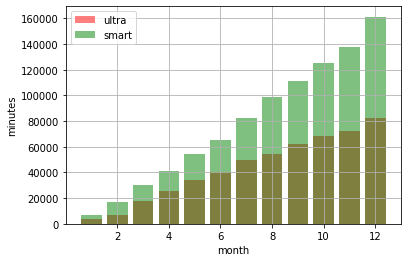

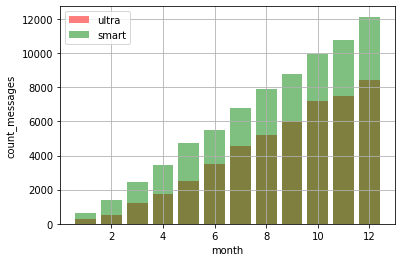

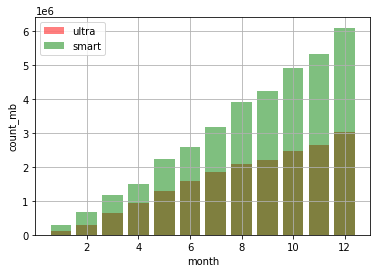

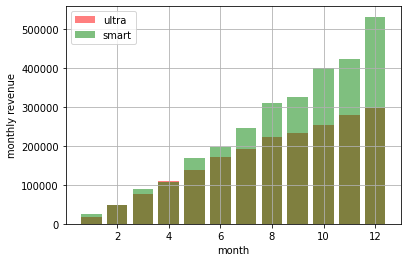

In [31]:
#Построим гистограмму сравнения расхода трафика пользователей двух тарифов

id_user_group_ultra=id_user_group.query('tariff=="ultra"').reset_index(drop=True)
id_user_group_smart=id_user_group.query('tariff=="smart"').reset_index(drop=True)
for idx in ['minutes','count_messages', 'count_mb','monthly revenue']:
    plt.bar(id_user_group_ultra['month'], id_user_group_ultra[idx],label='ultra', alpha=0.5, color='r')
    plt.bar(id_user_group_smart['month'], id_user_group_smart[idx],label='smart', alpha=0.5, color='g')
    plt.xlabel('month')
    plt.ylabel(idx)
    plt.grid()
    plt.legend()
    plt.show()

Судя по гравфикам, пользователи тарифа 'smart' приносят гораздо больше выручки, чем пользователи другого тарифа. 
С каждым месяцем выручка увеличивается
Тоже самое можно сказать и про расход всего трафика.

In [37]:
id_user

,user_id,month,calls_count,minutes,count_messages,count_mb,tariff,city,monthly revenue
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,1950.0
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,1950.0
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,1950.0
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,1950.0
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19559.44,smart,Санкт-Петербург,1550.0
3212,1489,11.0,0.0,0.0,20.0,17491.56,smart,Санкт-Петербург,1150.0
3213,1489,12.0,0.0,0.0,35.0,17322.51,smart,Санкт-Петербург,950.0
3214,1128,3.0,0.0,0.0,0.0,0.00,ultra,Волжский,1950.0


In [38]:
id_user['count_mb']=id_user['count_mb']/1024

In [39]:
id_user

,user_id,month,calls_count,minutes,count_messages,count_mb,tariff,city,monthly revenue
0,1000,5.0,22.0,159.0,22.0,2.200674,ultra,Краснодар,1950.0
1,1000,6.0,43.0,172.0,60.0,22.689229,ultra,Краснодар,1950.0
2,1000,7.0,47.0,340.0,75.0,13.675430,ultra,Краснодар,1950.0
3,1000,8.0,52.0,408.0,81.0,13.726494,ultra,Краснодар,1950.0
4,1000,9.0,58.0,466.0,57.0,14.227451,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19.101016,smart,Санкт-Петербург,1550.0
3212,1489,11.0,0.0,0.0,20.0,17.081602,smart,Санкт-Петербург,1150.0
3213,1489,12.0,0.0,0.0,35.0,16.916514,smart,Санкт-Петербург,950.0
3214,1128,3.0,0.0,0.0,0.0,0.000000,ultra,Волжский,1950.0


In [40]:
(
    id_user
         .pivot_table(index = 'tariff', values = ['calls_count', 'minutes', 'count_messages',
       'count_mb', 'monthly revenue'], 
                                                                  aggfunc = ['mean', 'std', 'var'])
         .round(1)
         .rename(columns={'calls_count': 'кол-во звонков', 'minutes' : "мин-ты", 'count_messages':"смс",
       'count_mb':"Гб.", 'monthly revenue':"выручка"})
         .transpose()      
            )

tariff                  smart     ultra
mean кол-во звонков      58.4      73.3
     Гб.                 15.8      19.0
     смс                 33.4      49.3
     мин-ты             417.7     526.1
     выручка           1289.6    2070.0
std  кол-во звонков      26.0      44.0
     Гб.                  5.7       9.9
     смс                 28.2      47.8
     мин-ты             190.5     317.9
     выручка            818.4     376.0
var  кол-во звонков     674.1    1932.2
     Гб.                 33.0      97.3
     смс                797.0    2285.4
     мин-ты           36281.4  101052.5
     выручка         669730.8  141387.7

In [41]:
(
    id_user.query('tariff == "smart"')
                    [['calls_count', 'minutes', 'count_messages', 'count_mb', 'monthly revenue']]
                        .apply (['min', 'mean', 'median',  'max'])   
                        .round(1)
)

,calls_count,minutes,count_messages,count_mb,monthly revenue
min,0.0,0.0,0.0,0.0,550.0
mean,58.4,417.7,33.4,15.8,1289.6
median,60.0,421.5,28.0,16.1,1021.0
max,198.0,1435.0,143.0,37.6,6770.0


In [42]:
(
    id_user.query('tariff == "ultra"')
                    [['calls_count', 'minutes', 'count_messages', 'count_mb', 'monthly revenue']]
                        .apply (['min', 'mean', 'median',  'max'])   
                        .round(1)
)

,calls_count,minutes,count_messages,count_mb,monthly revenue
min,0.0,0.0,0.0,0.0,1950.0
mean,73.3,526.1,49.3,19.0,2070.0
median,73.5,518.0,38.0,18.9,1950.0
max,244.0,1673.0,224.0,48.6,4800.0


Значения тарифов не сильно отличаются друг от друга, при этом:
клиенты обоих тарифов мало пользуются смс-услугами;
примерно одинаково говорят по телефону;
пользователи тарифа smart часто превышают лимит интернет-тарфика.
Большая выручка идет от клиентов smart из-за большего количества пользователей по тарифу.
Но больше выручки, в среднем, приносят пользователи тарифа ультра.

<AxesSubplot:title={'center':'var'}, xlabel='tariff'>

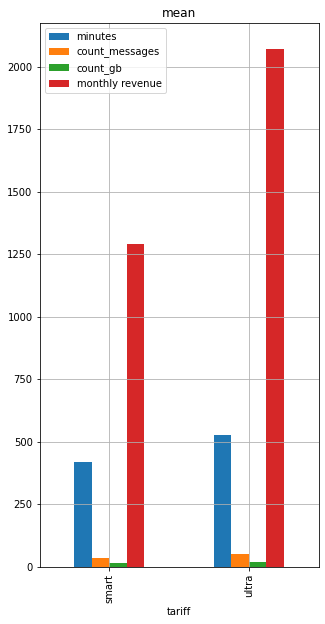

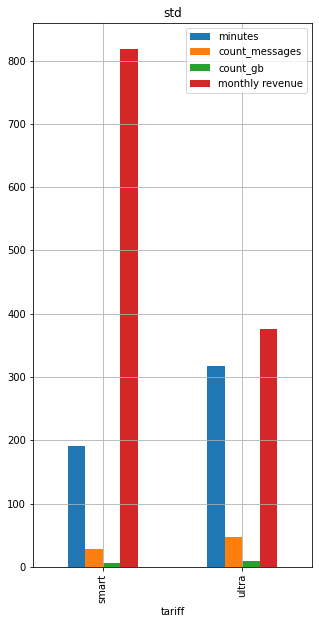

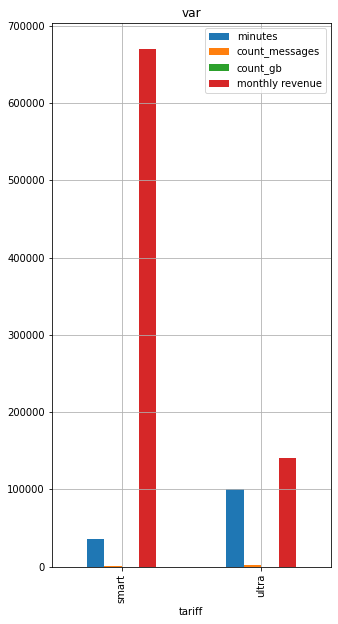

In [44]:
id_user=id_user.rename(columns={'count_mb':"count_gb"})
for_plot=id_user.drop(columns=['user_id', 'month', 'calls_count', 'city'])
for_plot.groupby(by='tariff').agg('mean').plot(kind='bar', title ='mean', grid=True, figsize=(5,10))
for_plot.groupby(by='tariff').agg('std').plot(kind='bar', title ='std', grid=True, figsize=(5,10))
for_plot.groupby(by='tariff').agg('var').plot(kind='bar', title ='var', grid=True, figsize=(5,10))

Графики подтверждают предыдущие выводы

In [46]:
uniq_smart=id_user.query('tariff=="smart"')
uniq_ultra=id_user.query('tariff=="ultra"')
smart_tarif_min=500
smart_tarif_mes=50
smart_tarif_gb=15


uniic_min=uniq_smart[uniq_smart['minutes'] > smart_tarif_min].count()
uniic_min=uniic_min['minutes']

uniic_mes=uniq_smart[uniq_smart['count_messages'] > smart_tarif_mes].count()
uniic_mes=uniic_mes['count_messages']

uniic_gb=uniq_smart[uniq_smart['count_gb'] > smart_tarif_gb].count()
uniic_gb=uniic_gb['count_gb']

print('Доля пользователей, превышающих лимит тарифа смарт по минутам: ',uniic_min*100/uniq_smart['minutes'].count())
print('Доля пользователей, превышающих лимит тарифа смарт по сообщениям: ',uniic_mes*100/uniq_smart['count_messages'].count())
print('Доля пользователей, превышающих лимит тарифа смарт по гигабайтам: ',uniic_gb*100/uniq_smart['count_gb'].count())

uniq_smart['user_id'].nunique()
uniq_ultra['user_id'].nunique()

Доля пользователей, превышающих лимит тарифа смарт по минутам:  33.81165919282511
Доля пользователей, превышающих лимит тарифа смарт по сообщениям:  25.291479820627803
Доля пользователей, превышающих лимит тарифа смарт по гигабайтам:  58.47533632286996


149

## Проверим гипотезы

Сформируем нулевую и альтернативную гипотезы:
H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются

In [48]:
import scipy.stats as st
alpha = 0.05
ultra = id_user.loc[id_user.loc[:,'tariff'] == 'ultra']['monthly revenue']
smart = id_user.loc[id_user.loc[:,'tariff'] == 'smart']['monthly revenue']
result = st.ttest_ind(ultra, smart) 
prob = result.pvalue
print("p-значение:{}".format(prob))
if prob > alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:8.081909555489933e-161
Не получилось отвергнуть нулевую гипотезу


p-значение:8.081909555489933e-161 - крайне маленькое,
что означает крайне малую вероятность совпадения средних значений.

Принимаем гипотезу - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформируем нулевую и альтернативную гипотезы:
H0 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
H1 - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

In [52]:
moscow = id_user.loc[id_user.loc[:,'city'] == 'Москва']['monthly revenue']
other = id_user.loc[id_user.loc[:,'city'] != 'Москва']['monthly revenue']
result_city = st.ttest_ind(moscow,other,equal_var=False) 
city = result_city.pvalue
print("p-значение:{}".format(city))
alpha = 0.05
if city > alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:0.5216952110000279
Отвергаем нулевую гипотезу


p-значение - вероятность ошибочного предположения *
p-значение:0.5216952110000279, что говорит нам о большой вероятности ошибки.*
Тк p-value больше 5%*

Принимаем гипотезу - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов

P-value - это вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, *
    что нулевая гипотеза верна. *
Если alpha=0.05 - допускается вероятность получить ошибочный результат сосавляет не больше 5%, а по расчетам 52%*
вероятность ошибки при отклонении нулевой гипотезы (ошибки первого рода)

## Общий  вывод

Данные пришли к нам в хорошем состоянии
Пользователи обоих тарифов укладываются в выделенные минуты разговора. С каждым смесяцем пользователи дольше говорят по телефону
Смс не так популярна у пользователей, видимо, соцсети заменяют им эту потребность
Пользователи много сидят в интернете, примерно расходуя 10-20 гб в месяц, поэтому и переплачивают на тарифе смарт
Гипотеза о различии среднейвыручки тарифов подтвердилась
Гипотеза об отличии средней выручки пользователей Москвы и регионов не подтвердилась
Пользователи тарифа смарт почти в 2 раза больше расходуют трафик, выходя за его пределы и оплачивая сверх нормы. 1230,2 р. в среднем в месяц, при месячной стоимости тарифа - 550 р.. А пользователи Тарифа ультра, при месячной стоимости тарифа в 1950 р., в среднем платят 2059.8 р.
Больше выручки, в среднем, приносят пользователи тарифа ультра: 2059.8 р. против 1230,2 р. за тариф ультра на одного пользователя.
Рекламный бюджет стоит направить в сторону тарифа смарт, тк больший доход идет от оплаты сверх лимитов тарифа.
На настоящий момент кодовая выручка тарифа смарт составляет 2743331 р, против тарифа ультра с выручкой 2030931 р. При этом, количество уникальных пользователей тарифа смарт - 351, ультра - 149.
Соответственно, выручка на доного пользователя тарифа смарт -7815 р., ультра -13630 р.





In [58]:
import seaborn as sns

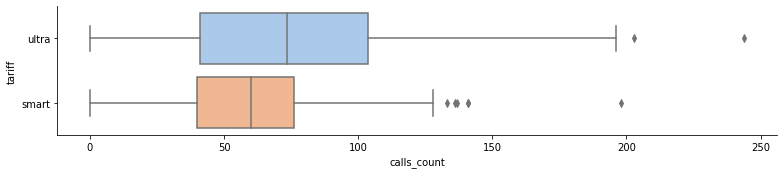

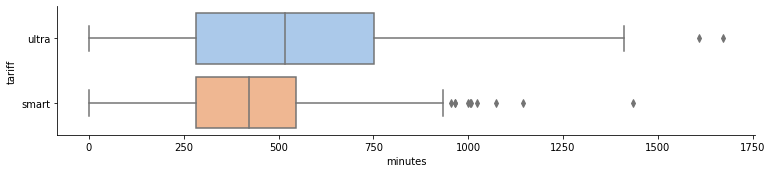

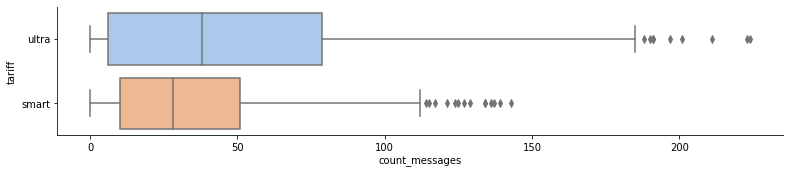

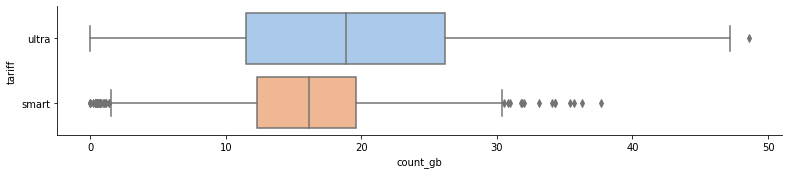

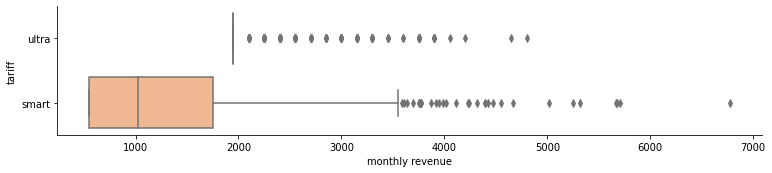

In [59]:
for column in ['calls_count', 'minutes', 'count_messages',
       'count_gb', 'monthly revenue']:    
    g = sns.catplot(y='tariff', x=column, kind="box", data=id_user, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)